In [50]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

In [51]:
def custom_activation(x):
    return tf.sin(x)

In [52]:
NN = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input((2,)),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=32, activation=custom_activation),
        # tf.keras.layers.Dense(units=32, activation=custom_activation),
        tf.keras.layers.Dense(units=1),
    ]
)

NN.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,185 (4.63 KB)

 Trainable params: 1,185 (4.63 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
optm = tf.keras.optimizers.Adam(learning_rate=0.001)
NN.compile(optimizer="Adam", loss="mean_squared_error")

In [54]:
tf_pi = tf.constant(np.pi)


def real_u(x, y):
    return np.sin(np.pi * x) * np.sin(np.pi * y)


def f(x, y):
    return -2 * tf_pi * tf_pi * tf.sin(tf_pi * y) * tf.sin(tf_pi * x)

### Params

In [55]:
grid_size = (50, 50)
x_limits = (0, 2)
y_limits = (0, 2)
border_grid_size = (50, 50)
koef = 2

In [56]:
x = np.linspace(x_limits[0], x_limits[1], border_grid_size[0], dtype=np.float32)
y = np.linspace(y_limits[0], y_limits[1], border_grid_size[1], dtype=np.float32)
# y = np.random.uniform(1, 10, 10)
x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))

border = train_coord.reshape(border_grid_size[0], border_grid_size[1], 2)
border_01 = np.append(border[0], border[0][..., [1, 0]])
border_02 = np.append(border[border_grid_size[0] - 1], border[border_grid_size[0] - 1][..., [1, 0]])
border = np.append(border_01, border_02).reshape(border_grid_size[0] * 4, 2)

x = np.linspace(x_limits[0], x_limits[1], grid_size[0], dtype=np.float32)
y = np.linspace(y_limits[0], y_limits[1], grid_size[1], dtype=np.float32)

x, y = np.meshgrid(x, y)
train_coord = np.column_stack((x.flatten(), y.flatten()))
# train_coord = x
train_loss_record = []

In [57]:
# @tf.function
def ode_system(coord, net, border):
    # set type to avoid overcalculations
    border = tf.constant(border, dtype=tf.float32)
    coord = tf.constant(coord, dtype=tf.float32)
    with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape:
        tape.watch(coord)
        with tf.GradientTape(watch_accessed_variables=False, persistent=True) as tape1:
            tape1.watch(coord)
            u = net(coord)
        grad_u = tape1.gradient(u, coord)
        du_dx = grad_u[..., 0]
        du_dy = grad_u[..., 1]
        del tape1

    d2u_dx2 = tape.gradient(du_dx, coord)[..., 0]
    d2u_dy2 = tape.gradient(du_dy, coord)[..., 1]
    del tape
    
    x = coord[..., 0]
    y = coord[..., 1]
    ode_loss = d2u_dx2 + d2u_dy2 - f(x, y)
    IC_loss = net(border) - tf.zeros((len(border), 1))

    square_loss = tf.square(ode_loss) + koef * tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

epoch: 0 loss: 93.81037
epoch: 50 loss: 90.64829
epoch: 100 loss: 70.2798
epoch: 150 loss: 36.83466
epoch: 200 loss: 22.69933
epoch: 250 loss: 8.59223
epoch: 300 loss: 2.1042607
epoch: 350 loss: 0.76920927
epoch: 400 loss: 0.6025748
epoch: 450 loss: 0.51915866
epoch: 500 loss: 0.46821243
epoch: 550 loss: 0.42973882
epoch: 600 loss: 0.3969188
epoch: 650 loss: 0.36817977
epoch: 700 loss: 0.3428879
epoch: 750 loss: 0.31981573
epoch: 800 loss: 0.2994868
epoch: 850 loss: 0.28072742
epoch: 900 loss: 0.26375976
epoch: 950 loss: 0.24823344
epoch: 1000 loss: 0.23365802
epoch: 1050 loss: 0.22014657
epoch: 1100 loss: 0.20745263
epoch: 1150 loss: 0.1955763
epoch: 1200 loss: 0.18433782
epoch: 1250 loss: 0.1738095
epoch: 1300 loss: 0.16376087
epoch: 1350 loss: 0.15389195
epoch: 1400 loss: 0.14481503
epoch: 1450 loss: 0.13634904
epoch: 1500 loss: 0.12770233
epoch: 1550 loss: 0.119839795
epoch: 1600 loss: 0.11233815
epoch: 1650 loss: 0.10502122
epoch: 1700 loss: 0.09833944


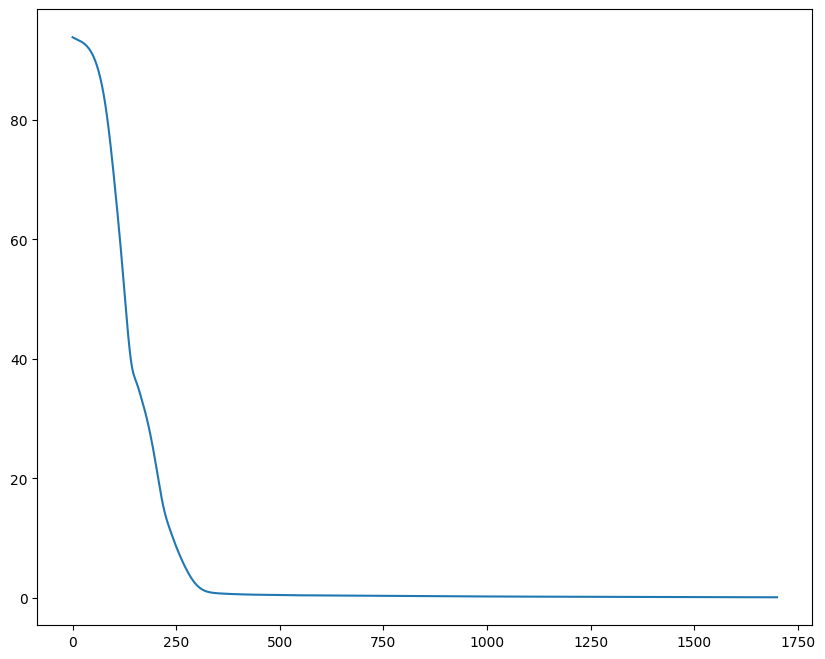

In [58]:
# train model
# /physical_device:GPU:0
# with tf.device('gpu:0'):
def train():
    for itr in range(6000):
        with tf.GradientTape() as tape:
            train_loss = ode_system(train_coord, NN, border)
            train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

        if itr % 50 == 0:
            # USE TF.PRINT()!!!
            tf.print("epoch:", itr, "loss:", train_loss.numpy())   
            if train_loss < 0.1:
                break

plt.figure(figsize=(10, 8))
plt.plot(train_loss_record)
plt.show()

In [59]:
# NN.save("model.keras")
# NN = tf.keras.models.load_model("my_model.keras")

I0000 00:00:1726423148.254446   15726 service.cc:146] XLA service 0x724e7c0039b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726423148.254493   15726 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-09-15 20:59:08.273654: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


46/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

I0000 00:00:1726423149.280746   15726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step


[(0.0, 2.0),
 (0.0, 2.0),
 Text(0.5, 0, 'X'),
 Text(0.5, 0.5, 'Y'),
 Text(0.5, 0, 'Z')]

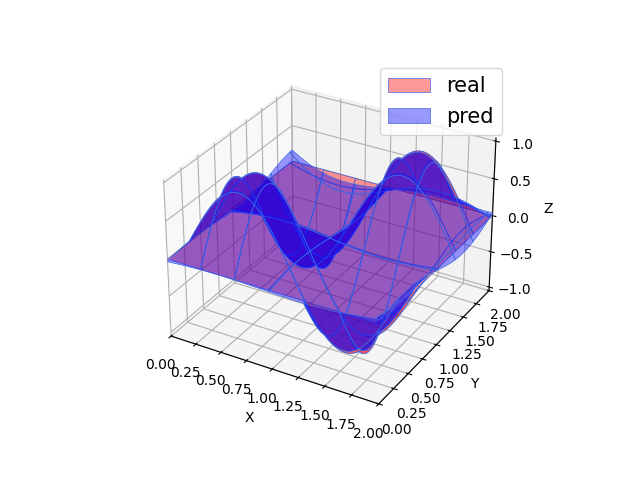

In [60]:
%matplotlib widget
test_x = np.linspace(x_limits[0], x_limits[1], grid_size[0])
test_y = np.linspace(x_limits[0], x_limits[1], grid_size[1])
test_x, test_y = np.meshgrid(test_x, test_y)

train_u = real_u(x, y)
true_u = real_u(test_x, test_y)
test_coord = np.column_stack((test_x.flatten(), test_y.flatten()))
pred_coord = list()
for _x in x[0]:
    for _y in x[0]:
        pred_coord.append([_x, _y])
pred_u = NN.predict(np.array(pred_coord)).ravel().reshape(grid_size[0], grid_size[1])
ax = plt.figure().add_subplot(projection="3d")
ax.plot_surface(
    test_x,
    test_y,
    true_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.4,
    # cmap="BuGn",
    facecolor="red",
    label="real"
)
ax.plot_surface(
    x,
    y,
    pred_u,
    edgecolor="royalblue",
    lw=0.5,
    rstride=8,
    cstride=8,
    alpha=0.4,
    # cmap="plasma",
    facecolor="blue",
    label="pred",
)
# ax.scatter(x, y, train_u, s=0.5, label="train")
ax.legend(fontsize=15)
ax.set(xlim=x_limits, ylim=y_limits, xlabel="X", ylabel="Y", zlabel="Z")

# Accuracy calculation

In [61]:
# Calculate the number of correct predictions
correct_predictions = np.sum(np.isclose(pred_u, true_u, rtol=0.1))

# Calculate the total number of predictions
total_predictions = np.prod(grid_size)

# Calculate the accuracy
accuracy = correct_predictions / total_predictions

print("Accuracy:", accuracy)

Accuracy: 0.6432
